In [1]:
from utils.extract_windspeed import WindSpeedExtractor
from utils.preprocessing import read_turbine_positions
import numpy as np
from utils.rl_utils import create_validation_points
from utils.visualization import plot_mean_absolute_speed_subplot
from matplotlib import pyplot as plt
from stable_baselines3 import SAC
from experiments.LESReinforcement.env_continuous import create_env

D:\AI2P\repo\experiments\LESReinforcement\env_continuous.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_case01/pignn_best.pt")

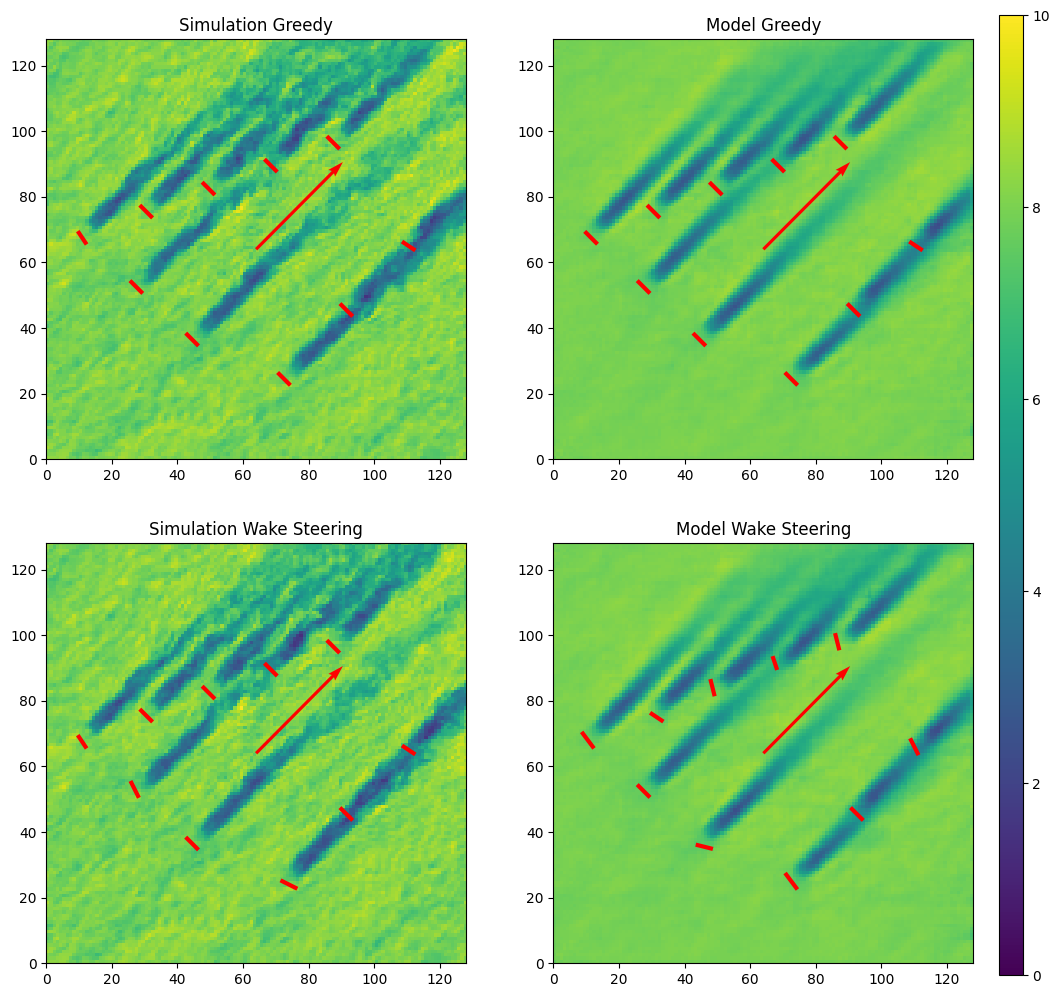

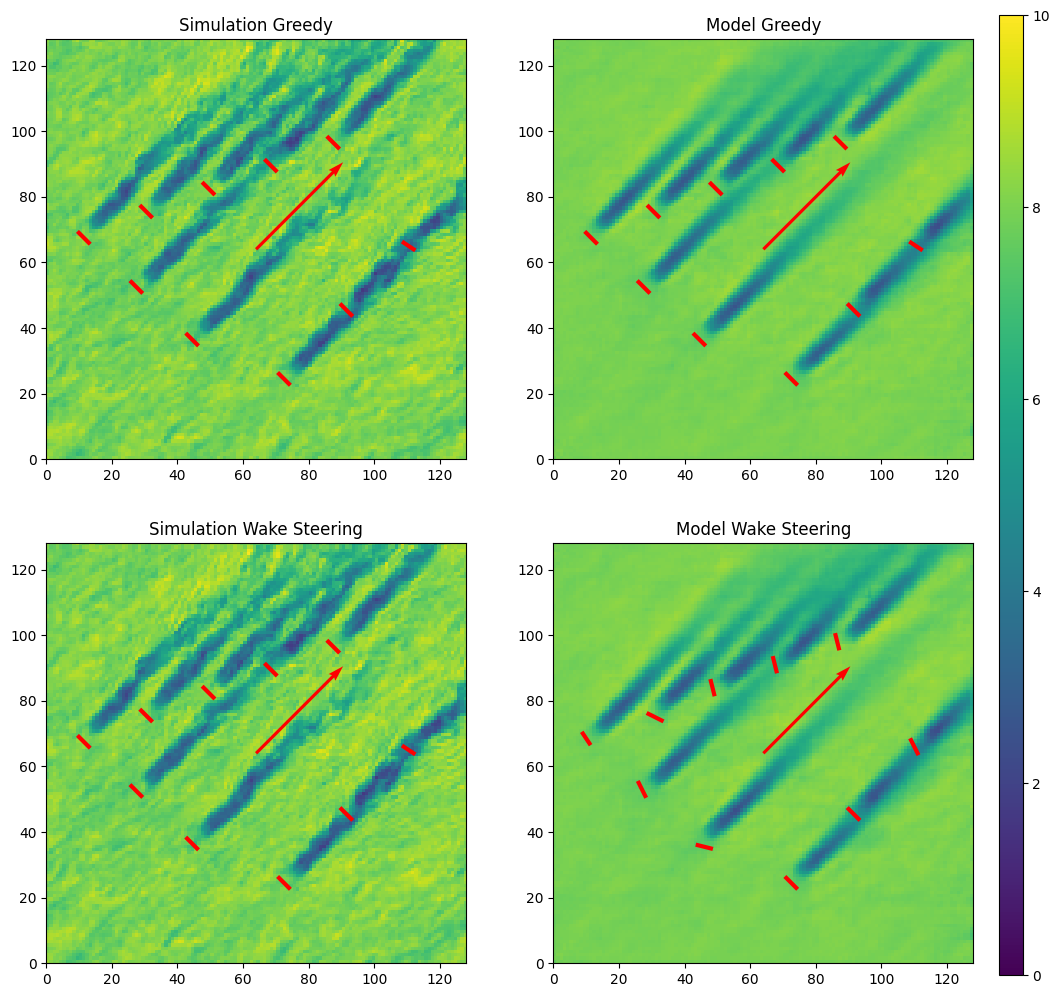

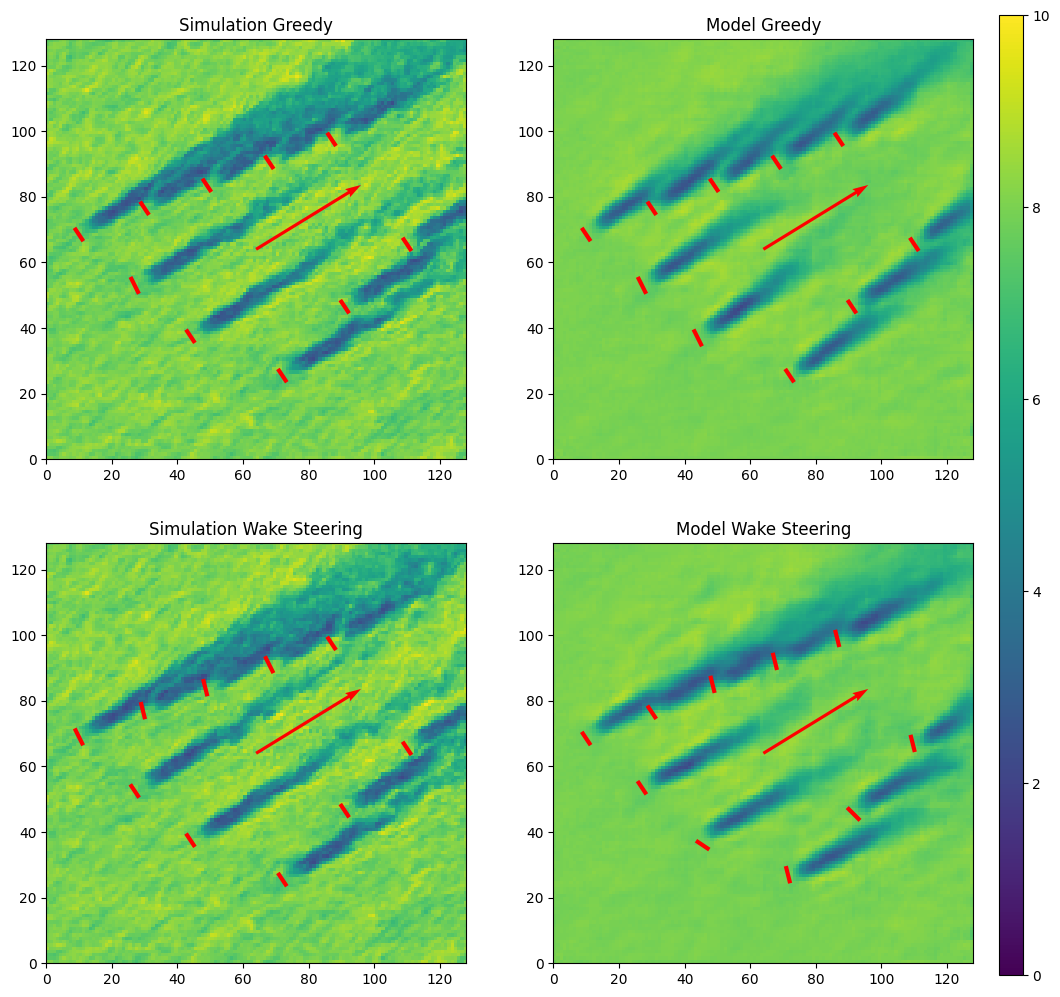

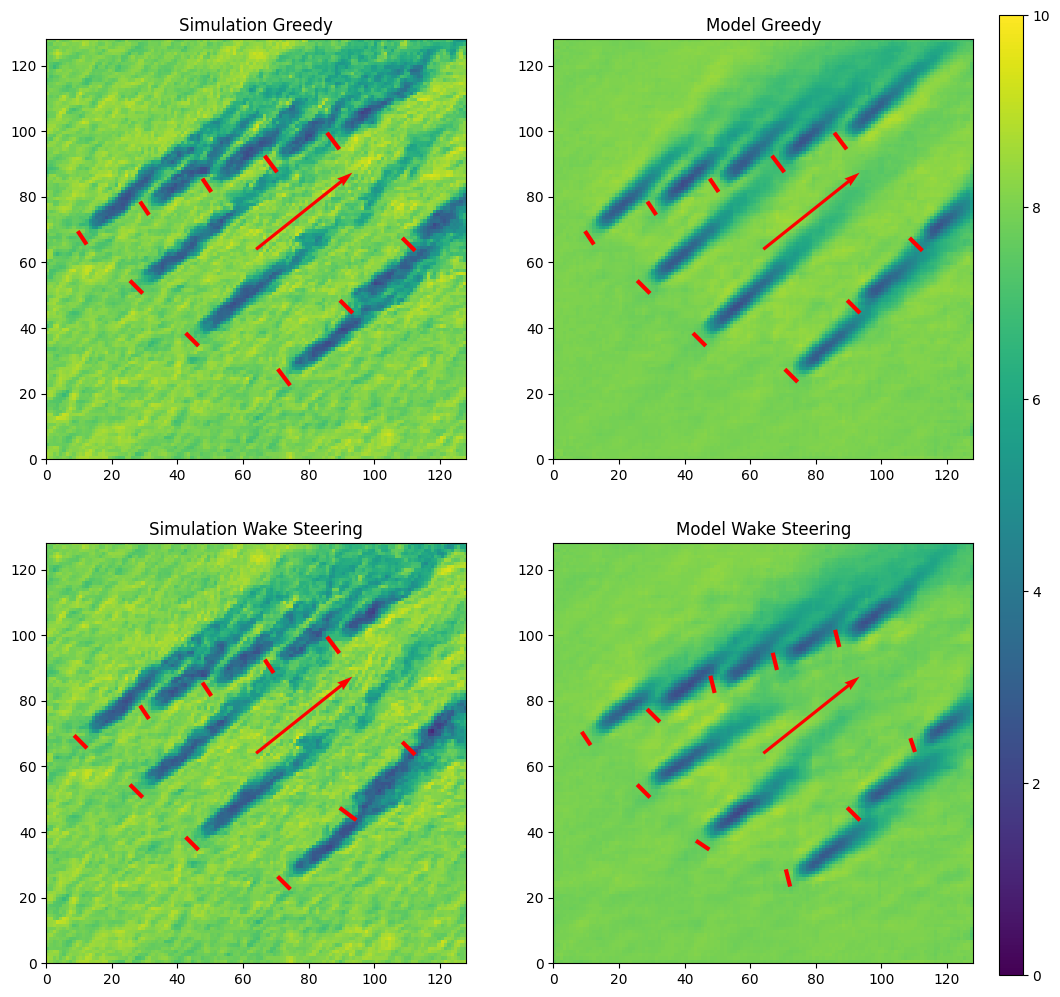

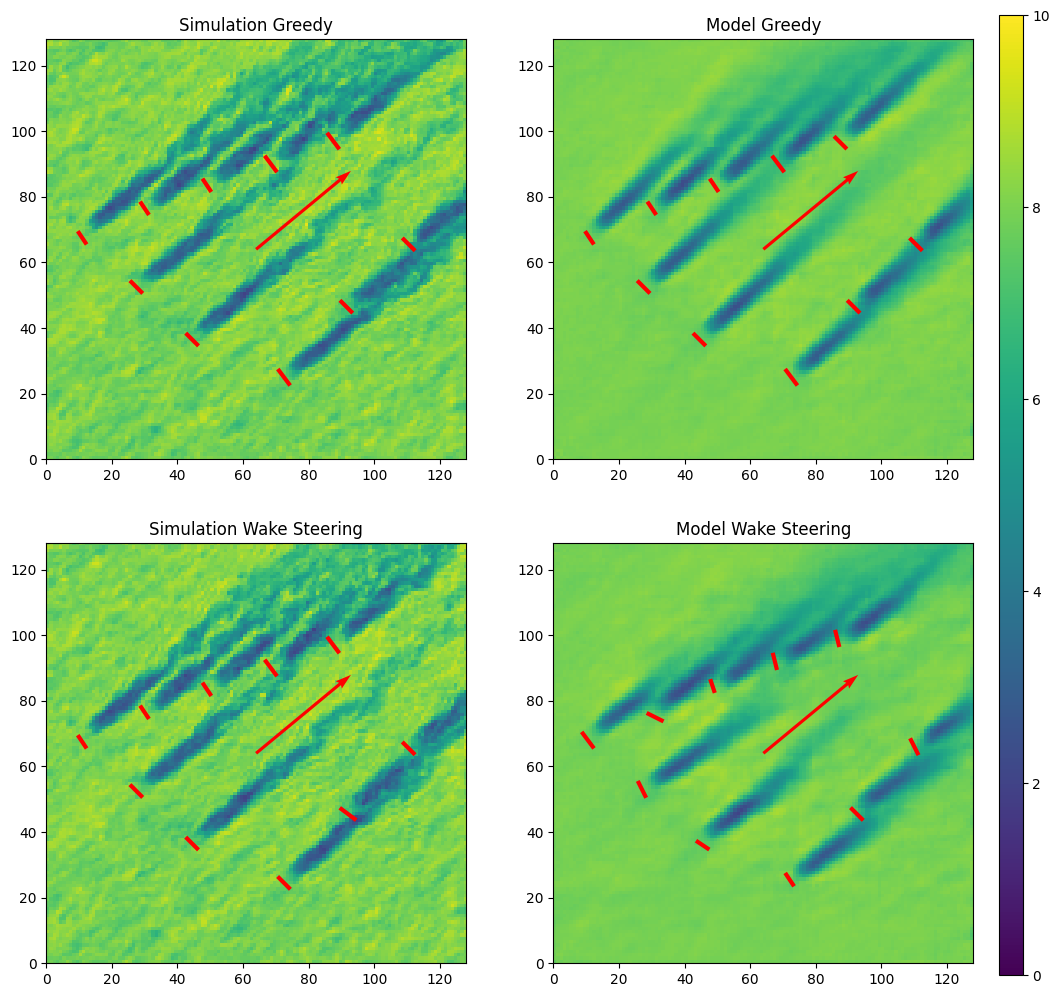

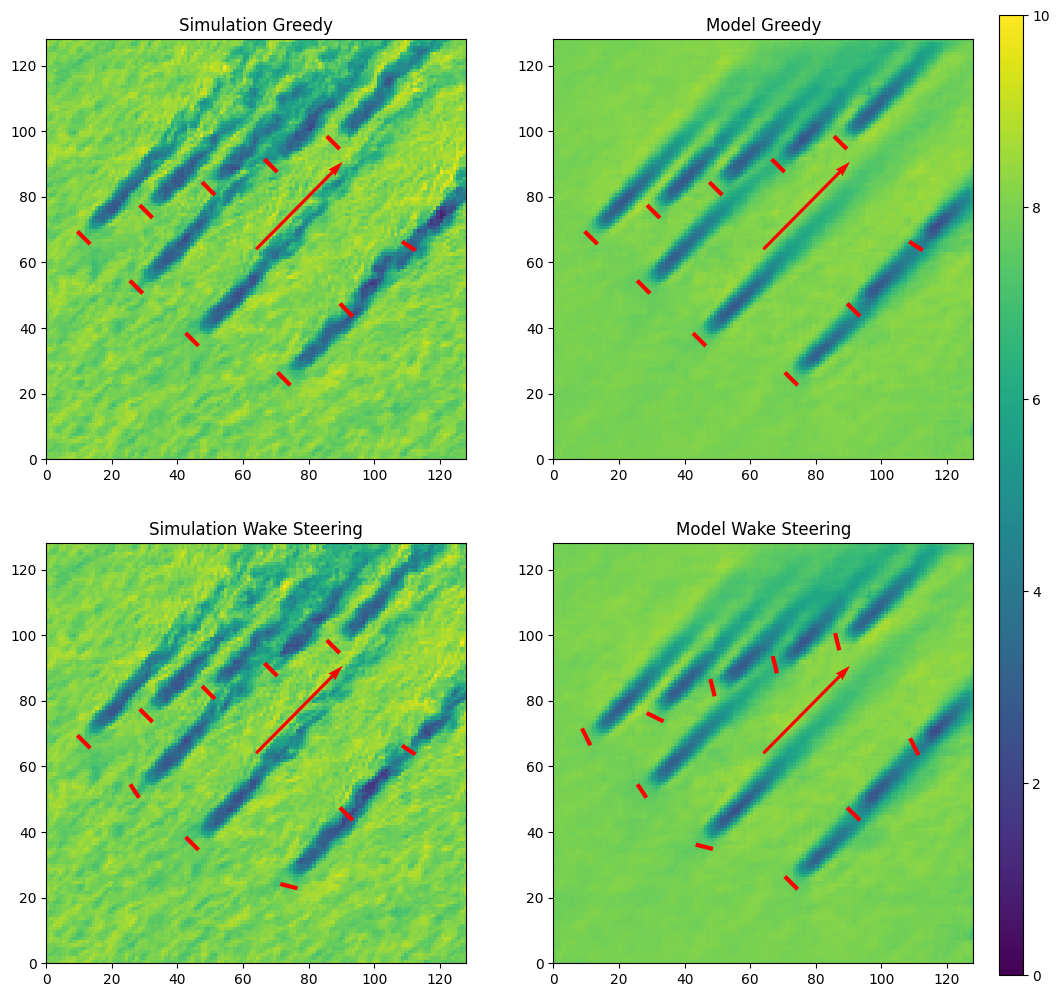

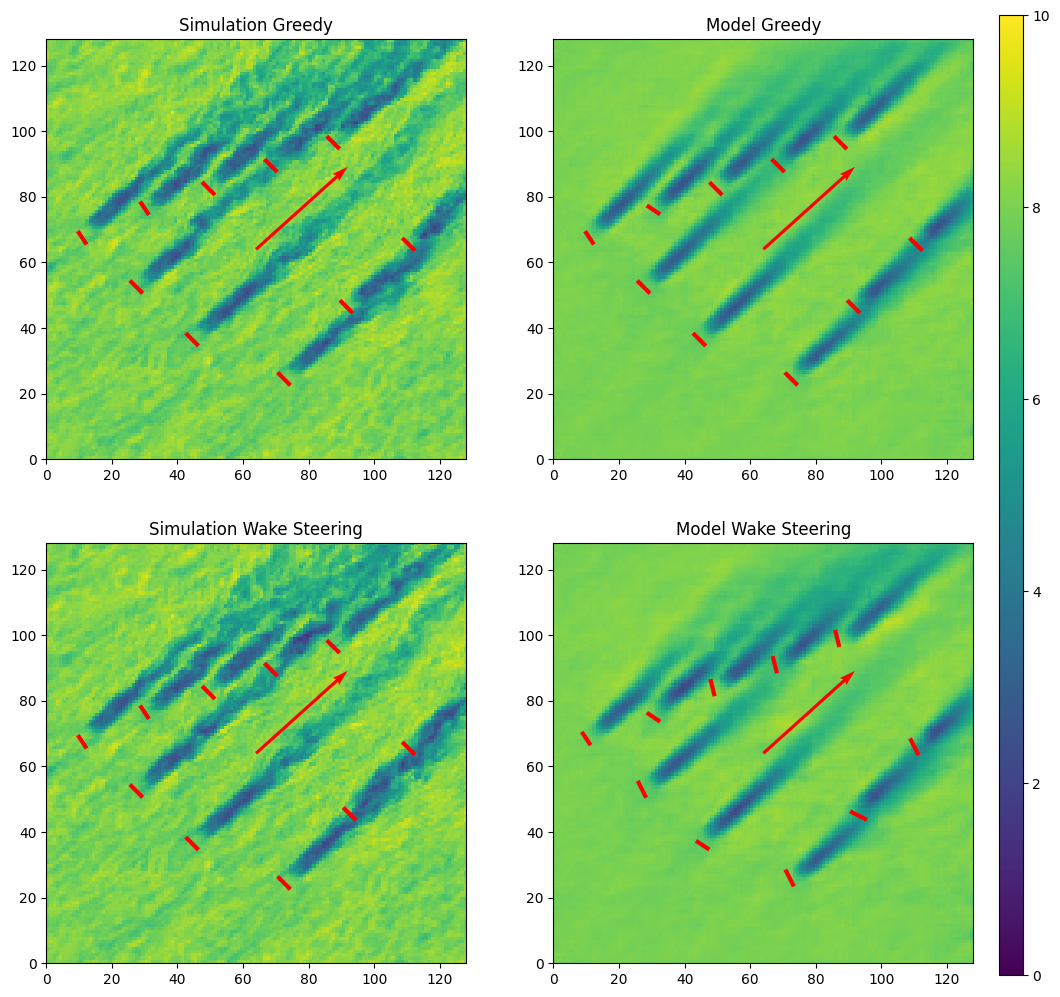

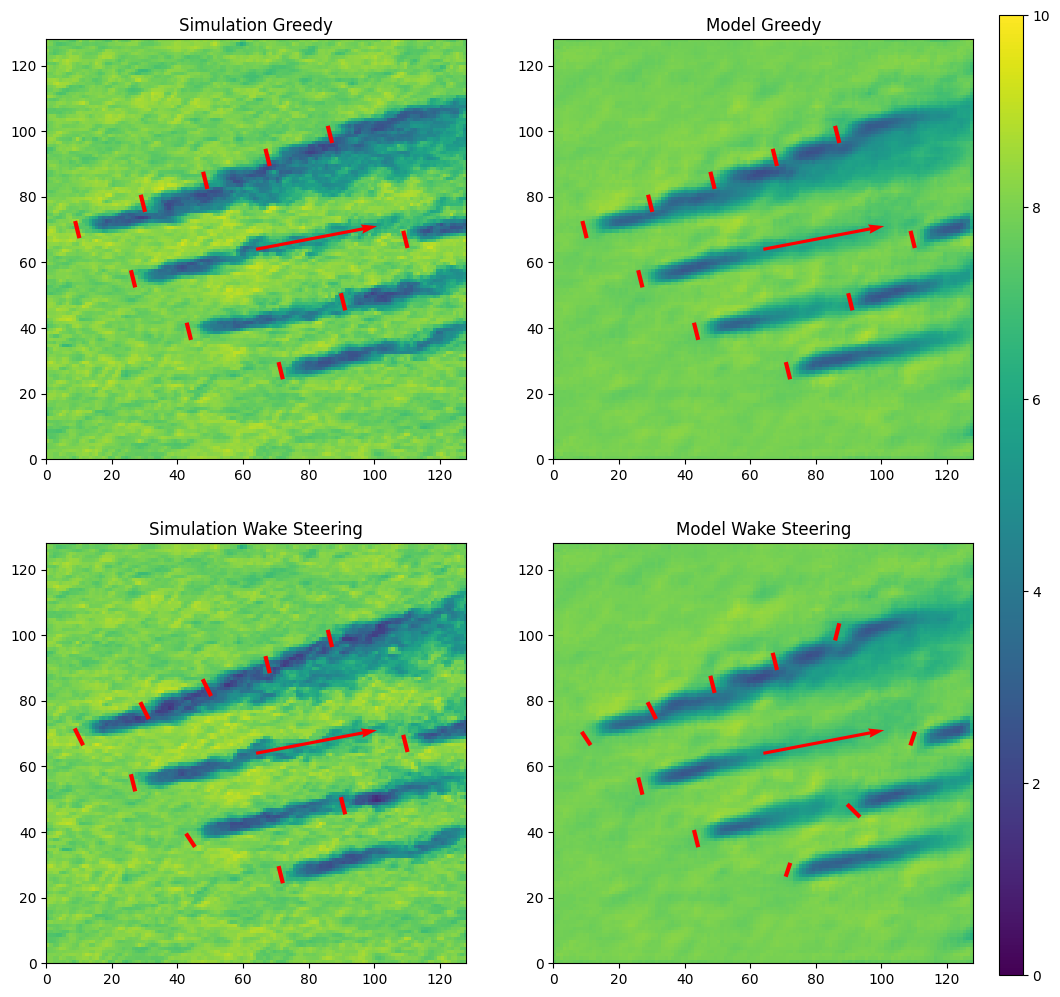

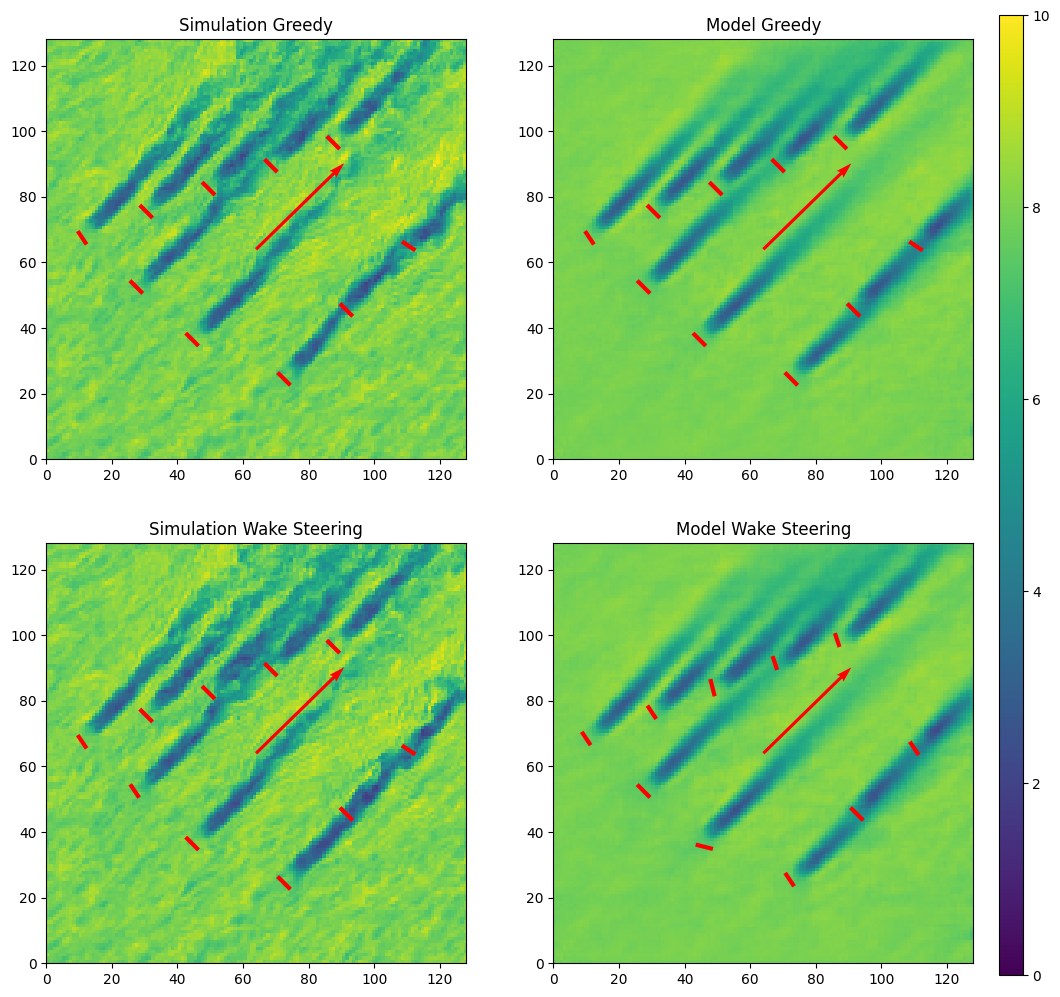

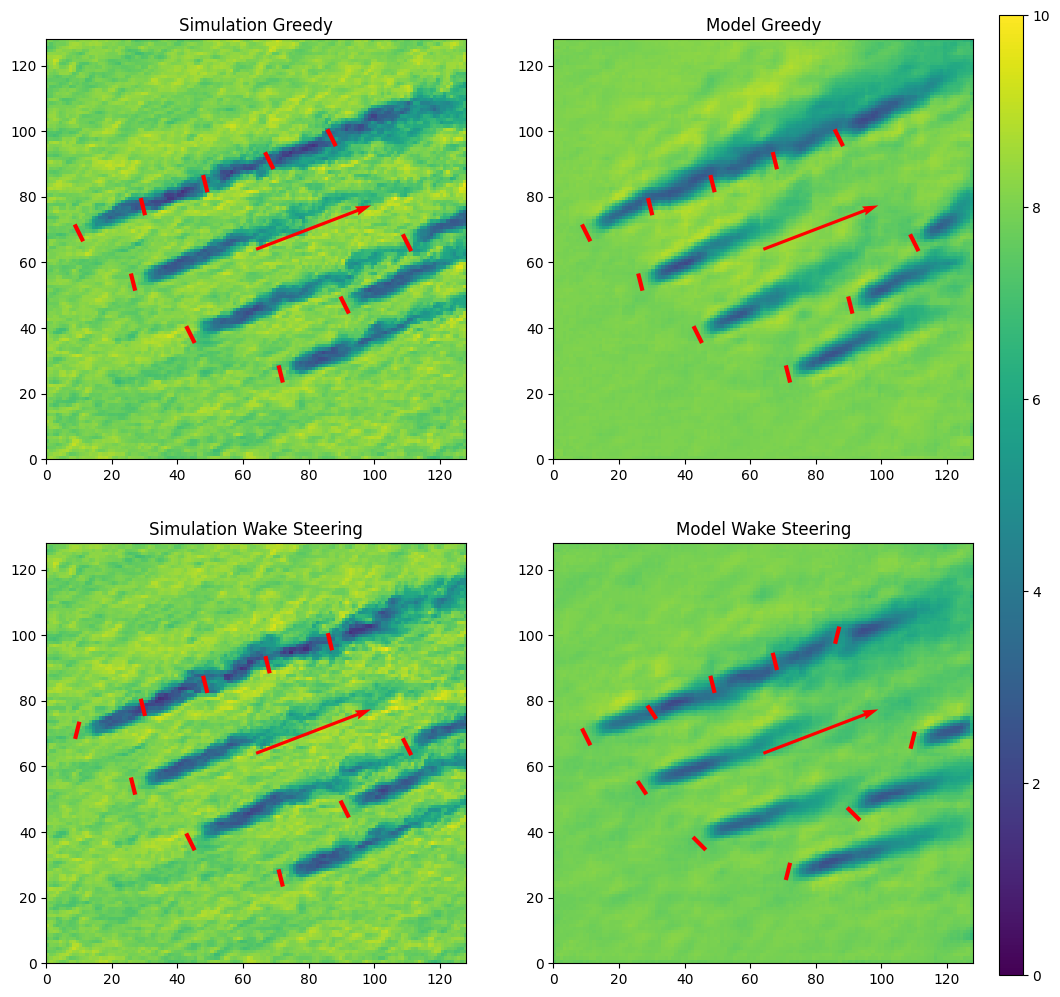

In [2]:
env = create_env(render_mode="rgb_array")
model = SAC.load("SACTurbineEnvModel")

case_nr = 1
seed = 42
num_val_points = 10
env = create_env()

turbines = "12_to_15" if case_nr == 1 else "06_to_09" if case_nr == 2 else "00_to_03"
layout_file = f"../../data/Case_0{case_nr}/HKN_{turbines}_layout_balanced.csv"
turbine_locations = read_turbine_positions(layout_file)
val_points = create_validation_points(case_nr, num_val_points, map_size=(128, 128), return_maps=True)
avg_sim_greedy_power = np.mean([point['greedy_power'] for point in val_points])
avg_sim_steering_power = np.mean([point['wake_power'] for point in val_points])

greedy_val_power = []
model_val_power = []

wind_speed_extractor = WindSpeedExtractor(turbine_locations, 128)

for val_point in val_points:
    greedy_yaws = np.ones(10, dtype=float) * val_point["wind_direction"]
    greedy_actions = np.zeros(10, dtype=float)
    options = {"wind_direction": np.array([val_point["wind_direction"]]), "yaws": greedy_yaws}

    # Simulation greedy
    sim_greedy_turb_pixels = []
    wind_speed_extractor(val_point["greedy_map"], val_point["wind_direction"], val_point["greedy_yaws"], sim_greedy_turb_pixels)

    # Simulation wake steering
    sim_wake_turb_pixels = []
    wind_speed_extractor(val_point["wake_map"], val_point["wind_direction"], val_point["wake_yaws"], sim_wake_turb_pixels)

    # Model greedy
    env.reset(seed=seed, options=options)
    _, rewards_greedy, _, _, info_greedy = env.step(greedy_actions)
    greedy_val_power.append(rewards_greedy)
    model_greedy_map, wind_vec, model_greedy_turb_pixels = env.get_render_info()

    # Model wake steering
    obs, info = env.reset(seed=seed, options=options)
    action, states = model.predict(obs)
    _, rewards_model, _, _, info_model = env.step(action)
    model_val_power.append(rewards_model)
    model_wake_map, _, model_wake_turb_pixels = env.get_render_info()

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    img1 = plot_mean_absolute_speed_subplot(axes[0, 0], val_point["greedy_map"], wind_vec, layout_file, sim_greedy_turb_pixels, color_bar=False)
    plot_mean_absolute_speed_subplot(axes[0, 1], model_greedy_map, wind_vec, layout_file, model_greedy_turb_pixels, color_bar=False)
    plot_mean_absolute_speed_subplot(axes[1, 0], val_point["wake_map"], wind_vec, layout_file, sim_wake_turb_pixels, color_bar=False)
    plot_mean_absolute_speed_subplot(axes[1, 1], model_wake_map, wind_vec, layout_file, model_wake_turb_pixels, color_bar=False)

    axes[0, 0].set_title('Simulation Greedy')
    axes[0, 1].set_title('Model Greedy')
    axes[1, 0].set_title('Simulation Wake Steering')
    axes[1, 1].set_title('Model Wake Steering')
    axes[0, 0].set_aspect('equal', adjustable='box')
    axes[0, 1].set_aspect('equal', adjustable='box')
    axes[1, 0].set_aspect('equal', adjustable='box')
    axes[1, 1].set_aspect('equal', adjustable='box')

    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    fig.colorbar(img1, cax=cbar_ax, orientation='vertical')

mean_greedy_power = np.mean(greedy_val_power)
mean_steering_power = np.mean(model_val_power)